# **DeepTweets Challenge**

## Approach

This challenge is about classifing new tweets by assigning labels based on an already classified dataset of tweets. There are two labels, so this is a *binary classification*. However, it is important to not that a tweet might not fit in either one and hence mislead the classification. Thus we should define a set of features that would count as a valid tweet, so that it would corelate with its label.

Each tweet is basically a string representing a text. However, it might have some *properties*. Such properties may give a tweet an *extended meaning*. However, a tweet has also a *category* that reflects the importance of its properties, which *in itself is a property* of the tweet.

### Tweet Properties

- *Hashtags*: a string that comes after `#` e.g. `#Here #2000Here #_Test123` are valid, but `test#here #123 #a` are not
- *Mentions*: a string that comes after `@` e.g. `@user @user123 @123_user` are valid, but `email@here.com tst@ @12` are not
- *URLs*: twitter's shortened ones only e.g. `http://t.co/hY45Ah1A`

### Tweet Categories

- *reply tweet*: *starts* with `@` e.g. `@user this is good @other` is valid but `.@some good` is not
- *retweet*: matching the pattern `RT mention:` 
   - *regular retweets* must **start** with prefix e.g. `RT @user: this is good`
   - *quote retweets* need to only **contain** the prefix `some thing RT @user: say word`
- *regular tweet*: is any tweet that is not in any of the other categories

## Application

This *binary classification* problems can be solved using the *Logistic Regression* model. But before training the model we have to turn tweets into a *mathematical model* by extracting their features.

And since each tweet is composed of terms, it is [advised](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) to build one based on the frequency of each term, because it *should* reflect the importance. This also kowns as a *Bag of Words* model, which would extract the features of the tweets by turning each property into a *vector* such that close properties are adjacent.

> *Each step has a section that elaborates on its implementation*

### Handling the data
1. [X] Preprocess the tweets
   - fix encoding, remove extra whitespaces, ...
1. [X] Filter the tweets by category
1. [X] Process the properties of tweets
   - such that we end up with a reduced version

### Modeling the ML algorithm
1. [X] Extract the features from the properties of the tweets
    - using TF-IDF as *Bag of Words* model
2. [X] Train the *Logistic Regression* model

## Insights
1. [X] Confusion Matrix
1. [X] ROC
1. [X] Match with reverse testing 

In [1]:
import gc

LANGUAGE = 'english'
ENCODING = 'latin-1'
ENCODING_ERROR_POLICY = "ignore"

!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 8.1 MB/s eta 0:00:00


> *default text encoding parameters, since it may contain non-ascii characters*

In [2]:
import pandas as pd

# shuffling the data is handy when debugging large datasets
train_df = pd.read_csv("../input/deeptweets/train.csv").sample(frac=1)
training_df = pd.read_csv("../input/deeptweets/training.csv");

assert train_df.size == pd.concat([train_df, training_df]).drop_duplicates().size

In [3]:
train_df.isna().sum()

TweetId      0
Label        0
TweetText    0
dtype: int64

> *Training data has no missing values*

## Word Lemmatization

The idea is to reduce each Tweet into a *subset of words which only contains the very critical words*.

Such words would **eventually** correlate with its label. even more, by using the concept of [Lemmatization](https://www.researchgate.net/publication/348306833_An_Interpretation_of_Lemmatization_and_Stemming_in_Natural_Language_Processing) we ensure that words would be in their root form.

> *Idea: Sort of getting a signature of the Tweet based on which the words it is composed of*. This also contains the hash-signature of the URL, if the Tweet has one


In [4]:
import spacy
import contractions
nlp = spacy.load("en_core_web_sm")

# reduce words into their common root form would improve the accuracy of IF-IDF model
# however, it may require additional processing to ensure the quality of the outcome
def lemmatise(text):
    text = ' '.join([contractions.fix(w) for w in text.split()])
    text = nlp(text)
    tokens = []
    for w in text:
        if w.lemma_.lower() not in nlp.Defaults.stop_words:
            tokens.append(w.lemma_.lower())
    return tokens

for row in train_df.head(10).iloc:
    lem = lemmatise(row.TweetText)
    ss = ' '.join(lem)
    print(row.TweetText, "\n", ss)
    print()

'VIDEO: In case you missed it- British Tennis players do the Harlem Shake http://t.co/jVCeZMn6CS #harlemshake RT &amp; share!' 
 ' video : case miss it- british tennis player harlem shake http://t.co/jvcezmn6cs # harlemshake rt & amp ; share ! '

'#WeDemandAVote for them: http://t.co/8oyTD7XF' 
 ' # wedemandavote : http://t.co/8oytd7xf '

'#Cybercrime &amp; #cybersecurity discussions with @Europol_EU &amp; @enisa_eu in @EP_justice from 3pm CET http://t.co/ImUNp9Z0' 
 ' # cybercrime & amp ; # cybersecurity discussion @europol_eu & amp ; @enisa_eu @ep_justice 3 pm cet http://t.co/imunp9z0 '

'RT @CapitalOne_Cup: RT by 9am tomorrow for a chance to win a special #CapitalOneCup Final @MitreSports ball! T&amp;Cs http://t.co/jUt0Ir ...' 
 ' rt @capitalone_cup : rt 9 tomorrow chance win special # capitalonecup final @mitresports ball ! t&amp;cs http://t.co/jut0ir ... '

'Want to know what goes on under the shell of an #F1 car? @CamsCorner lifts the lid http://t.co/cci8wqtn #AusGP' 
 ' want kno

## Train on news data

1. read news based on category
2. lemmatise the news 
3. train a bais model 
3. when reading tweet words, favour words with high bais 

# Tweet properties

Are any combination of: words, mentions, hashtags, urls and dates/years. However, since properties are not taken into account for all tweets equally, we need to explicitly filter the tweets by category to pick correct information. 

> For example, arguably, no need to cosider words in a reply as oppose to a quote retweet. Urls and dates are extracted from all categories.

In [5]:
import re
import calendar
import dateutil.parser as date_parser
from hashlib import md5

# compiling regular expressions because they will be exhaustively used
url_re = re.compile(r"\s?htt(.*?)(\s|$)")
tco_url_re = re.compile(r'https?://t.co/([\w]{6,15})')
mention_re = re.compile(r'[^\w]*@(\d*[a-zA-Z_][\w]*)')
hashtag_re = re.compile(r'[^\w]*#(\d*[a-zA-Z_][\w]*)')
reply_re = re.compile(r"^(@[\w]+\s)*")
quote_re = re.compile(r"^(.*?) (RT @[\w]+: .*)$")
rt_re = re.compile(r"^RT @[\w]+: (.*)$")
part_re = re.compile(r"([A-Z]+[a-z0-9]*)")
vs_suffix_re = re.compile(r'(v[s]?)$')                            # v or vs suffix as in FoovBar FoovsBar
s_suffix = re.compile(r'[^\w\s][sS]')                             # 's suffix as in who's
ponct_re = re.compile(r'[^\w\s]+')                                # non(characters or whitespace)
num_re = re.compile(r'\b\d+\b')                                   # only standalone numbers

# credits: https://stackoverflow.com/a/51123164
full_months = [month for month in calendar.month_name if month]
short_months = [d[:3] for d in full_months]
months = '|'.join(short_months + full_months)
sep = r'[.,/]?\s+'               # seperator
day = r'\d+'
year = r'\d+'
day_or_year = r'\d+(?:\w+)?'
date_re = re.compile(rf'(?:{day}{sep})?(?:{months}){sep}{day_or_year}(?:{sep}{year})?')
year_only_re = re.compile(r"(^|[\s\b])([12][890][\d]{2})([\s\b]|$)")

def parse_date(s):
    try:
        return date_parser.parse(s).date()
    except:
        print("`{}` could not be parse as date".format(s))
        pass

class TweetProperties(object):
    # takes a `text' representing the content, and then booleans to indicate extract methods
    def __init__(self, text="", words=False, mentions=False, hashtags=False, usehash=False):
        self.text = text
        self.texthash = [md5(text.encode(ENCODING)).hexdigest()] if usehash else []
        self.urls = []
        
        self.prop_words = words
        self.words = []  
        self.extended_words = []
        
        self.prop_mentions = mentions
        self.mentions = []
        
        self.prop_hashtags = hashtags
        self.hashtags = []
        
        self.dates = []
        self.years = []
        if len(self.text) != 0:
            self.process()

    def __str__(self):
        split_date = lambda d: str(d) #' '.join(str(d).split('-'))
        return (
            ' '.join(self.texthash) + " " + ' '.join(self.urls) + " " +
            ' '.join(
                [w for w in self.mentions + self.hashtags + self.words + list(set(self.extended_words)) if len(w) > 1] +
#                 [split_date(parse_date(y).replace(month=1, day=1)) for _, y, _ in self.years] +
                [str(y) for y in self.years] +
#                 [split_date(parse_date(d)) for d in self.dates]
                [str(d) for d in self.dates]
            ).lower()
        )

    def words_bag(self):
        return self.hashtags + self.words + self.extended_words

    # Since tweets can be embedded, this allows the extensions of properties
    def append(self, props):
        self.texthash += props.texthash
        self.words += props.words
        self.urls += props.urls
        self.mentions += props.mentions
        self.hashtags += props.hashtags
        self.dates += props.dates
        self.years += props.years
        self.extended_words += props.extended_words

    def extract_urls(self):
        self.urls = re.findall(tco_url_re, self.text)
        self.text = re.sub(url_re, " ", self.text)                     # extract       

    def extract_words(self):
        if not self.prop_words:
            return
        self.text = re.sub(s_suffix, ' ', self.text)                        
        self.text = re.sub(ponct_re, ' ', self.text)                       
        self.text = re.sub(num_re, ' ', self.text)
        for w in lemmatise(self.text):
            self.words.append(w) #+ list(syns)

    # extend word composions (LikeThis => Like)
    def extend_word_combinations(self, word_list):
        parts = []
        for tag in word_list:
            parts += re.findall(part_re, tag)

        lower = lambda lst: list(map(lambda tag: tag.lower(), lst))
        word_list = lower(word_list)
        parts = [w.lower() for w in lemmatise(' '.join(parts))]
        for word in parts:
            word = re.sub(vs_suffix_re, ' ', word)       
            if word not in word_list:
                self.extended_words.append(word)

    def extract_mentions(self):
        if self.prop_mentions:
            self.mentions = re.findall(mention_re, self.text)    
            self.extend_word_combinations(self.mentions)
        self.text = re.sub(mention_re, ' ', self.text)               # extract anyway

    def extract_hashtags(self):
        if self.prop_hashtags:
            self.hashtags = re.findall(hashtag_re, self.text)       
            self.extend_word_combinations(self.hashtags)
        self.text = re.sub(hashtag_re, ' ', self.text)               # extract anyway

    def extract_dates(self):
#         self.dates = re.findall(date_re, self.text)
        self.dates = [parse_date(d) for d in re.findall(date_re, self.text)]
        self.text = re.sub(date_re, " ", self.text)
#         self.years = re.findall(year_only_re, self.text)
#         self.years = [parse_date(y).replace(month=1, day=1) for _, y, _ in re.findall(year_only_re, self.text)]
        self.text = re.sub(year_only_re, " ", self.text)

    def process(self):
        # order does not matter for any of those because each one has a clean pattern
        self.extract_urls()
        self.extract_mentions()
        self.extract_hashtags()
        self.extract_dates()
        self.text = re.sub(r"[\s]+", " ", self.text.strip())
        # however, words would be lemmatized so the are the last to be extracted
        self.extract_words()

# since they can be stacked with quote retweets, the last retweet contains the actual tweet
# that has been retweeted, so it is handeled as regular tweets, unless it is a reply
#   - e.g. `RT @user1: RT @user2: this is a quote RT @user3: this is a tweet`
class Tweet(TweetProperties):
    def __init__(self, text):
        super().__init__()

        last = text
        while True:
            m = re.match(rt_re, last)
            while m is not None:
                last = m.group(1)
                m = re.match(rt_re, last)

            m = re.match(quote_re, last)
            if m is not None:
                self.process_quote(m.group(1))
                last = m.group(2)
            else:
                break

        self.process_quote(last)

    def process_quote(self, quote):
        if quote.startswith('@'):
            self.append(TweetProperties(re.sub(reply_re, " ", quote), hashtags=True, mentions=True))
        else:
            self.append(TweetProperties(quote, words=True, hashtags=True, mentions=True, usehash=True))  

for s in train_df[train_df.TweetId == 295566866284417024].iloc:
    print(s.TweetText)
    print()
    print(Tweet(s.TweetText))

'@HolterMedia See ya next year Petey ;)'

391316414f838aa175381a687910ba27  holtermedia ya year petey holter medium


## Further enhancement

- fix orthograph mistakes
- expand abbreviations
- detect patterns
- ...

In [6]:
SAMPLE_SIZE = 15

def sample_tweets(df=train_df, size=SAMPLE_SIZE, header=None, footer="",
                  parse=lambda row: "{:10} {}".format(row["Label"], row["TweetText"])):
    if header is not None:
        print(header)
    size = min(df.size, size)
    for s in df.head(size).iloc:
        print("{:20} {}".format(s["TweetId"], parse(s)))
    if footer is not None:
        print(footer)

sample_tweets()

  305275936465641472 Sports     'VIDEO: In case you missed it- British Tennis players do the Harlem Shake http://t.co/jVCeZMn6CS #harlemshake RT &amp; share!'
  304319182630162432 Politics   '#WeDemandAVote for them: http://t.co/8oyTD7XF'
  304221853910720513 Politics   '#Cybercrime &amp; #cybersecurity discussions with @Europol_EU &amp; @enisa_eu in @EP_justice from 3pm CET http://t.co/ImUNp9Z0'
  305608034414108672 Sports     'RT @CapitalOne_Cup: RT by 9am tomorrow for a chance to win a special #CapitalOneCup Final @MitreSports ball! T&amp;Cs http://t.co/jUt0Ir ...'
  301507964957777921 Sports     'Want to know what goes on under the shell of an #F1 car? @CamsCorner lifts the lid http://t.co/cci8wqtn #AusGP'
  306778809363988480 Sports     '@avatar81 See the previous tweet Dan - Aston Villa &amp; Everton.'
  297601154513260544 Politics   '2 February 1990 President FW de Klerk announces that the ANC would be legalised and that #NelsonMandela would be released from prison'
  3064811320

# Processing the tweets

Sparate tweets based on their category, then process each one and finally combine everyrhing again. 

> *this may be just a work around, and there would actually be a straight forward approach*

However, tweets *may contain unicode characters*, as well as some surrounding quotes which would mess up with results. So, before anything, we should preprocess all tweets.


In [7]:
import html
import string

extra_ws_re = re.compile(r"\s+")
surr_quotes_re = re.compile(r"^'(.*)'$")

def preprocess_text(text):
    text = text.encode(ENCODING, errors=ENCODING_ERROR_POLICY) \
        .decode('unicode_escape', errors=ENCODING_ERROR_POLICY)    # decode unicode characters
    text = ''.join([c for c in text if c in string.printable])                # remove non-printable characters    
    text = html.unescape(text)                                                # decode HTML characters
    
    text = re.sub(extra_ws_re, " ", text)                                          # remove extra whitespaces
    tmp = re.findall(surr_quotes_re, text)                                       # some Tweets have outter quotes
    if tmp:
        text = tmp[0]

    return text

## Idea to select words

1. TweetText -> TweetWords
2. stack TweetWords per Label
2. pick unique words per Label
3. plot results

## Idea to find relevant retweets
1. hash tweets
2. embed hash in retweets

## Idea to extend meaning with synonyms
1. when lemmatising take pos tag
2. only append word with same pos tag

## Idea exten meaning of composed words
1. try to match all words agains other words
1. if found, split by the match
> worldcup -> world cup

> *This phase basically ensures that we are dealing with genuine text*

In [8]:
from threading import Thread

pd.options.mode.chained_assignment = None # false warning

def process_tweets(df, log=True):
    df["TweetText"] = df["TweetText"].apply(preprocess_text)
    df["TweetWords"] = df.TweetText.apply(lambda text: str(Tweet(text)))
    
    if log:
        sample_tweets(df, parse=lambda row: "{} {} -> [{}]".format(row.Label, row.TweetText, row.TweetWords))
    return df

train_df = process_tweets(train_df)

  305275936465641472 Sports VIDEO: In case you missed it- British Tennis players do the Harlem Shake http://t.co/jVCeZMn6CS #harlemshake RT & share! -> [4e50a1a8442fc4f514ce16c0bb4b51a4 jVCeZMn6CS harlemshake video case miss british tennis player harlem shake rt share]
  304319182630162432 Politics #WeDemandAVote for them: http://t.co/8oyTD7XF -> [f152f1f8cdbdd3482adf36c738d4bba1 8oyTD7XF wedemandavote demand avote]
  304221853910720513 Politics #Cybercrime & #cybersecurity discussions with @Europol_EU & @enisa_eu in @EP_justice from 3pm CET http://t.co/ImUNp9Z0 -> [20ccc8fbf4be7a66dc979be8084e3d91 ImUNp9Z0 europol_eu enisa_eu ep_justice cybercrime cybersecurity discussion pm cet ep europol eu]
  305608034414108672 Sports RT @CapitalOne_Cup: RT by 9am tomorrow for a chance to win a special #CapitalOneCup Final @MitreSports ball! T&Cs http://t.co/jUt0Ir ... -> [ef4679c4b481827df7ae5f9775b51638 jUt0Ir mitresports capitalonecup rt tomorrow chance win special final ball cs sports mitre cap

# Classification Model

## Building a model

After reducing tweets into bare words/tokens, we can actually turn each tweet into a vector. 

However, vector clustering is relative tothe *quality* of the frequent tokens in each tweet, and how accurate they coorelate with the label. 


In [9]:
import sys, os
from warnings import simplefilter
if not sys.warnoptions:
    simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from pprint import pprint

X, y = train_df.TweetWords, train_df.Label
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, stratify=y
)

clf_pipe = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ('ensemble', VotingClassifier(
        voting='soft',
        estimators=[
            ('bnb', BernoulliNB()),
            ('lgreg', LogisticRegression()),
            ('rndf', RandomForestClassifier())
        ]
    ))
])

clf_params = {
    'vect__stop_words': ['english'],
    "vect__max_df": [0.5, 1.0],
    'vect__max_features': (5000, 10000),
    "vect__ngram_range": ((1, 1), (1, 2)),
    'tfidf__use_idf': [False, True],
    'tfidf__norm': ('l1', 'l2'),
    'ensemble__bnb__alpha': np.linspace(0.5, 10, 10),
    'ensemble__bnb__fit_prior': [True, False],
    'ensemble__lgreg__max_iter': (100, 1000),
    'ensemble__lgreg__solver': ['liblinear'],
    'ensemble__lgreg__penalty': ['l1', 'l2'],
    'ensemble__lgreg__C': np.linspace(10, 1000, 10),
    'ensemble__rndf__max_depth': [10, 20],
    'ensemble__rndf__min_samples_leaf': [2, 4],
    'ensemble__rndf__min_samples_split': [5, 10],
    'ensemble__rndf__n_estimators': [300, 600],
}

rsf = RepeatedStratifiedKFold()
clf = RandomizedSearchCV(clf_pipe, clf_params, scoring='roc_auc', verbose=1, cv=rsf)
clf.fit(X_train, y_train)

print("Best Score: ", clf.best_score_)
print("Best Params: ", end="")
pprint(clf.best_params_)

Fitting 50 folds for each of 10 candidates, totalling 500 fits
Best Score:  0.9878052675634399
Best Params: {'ensemble__bnb__alpha': 5.777777777777778,
 'ensemble__bnb__fit_prior': True,
 'ensemble__lgreg__C': 340.0,
 'ensemble__lgreg__max_iter': 100,
 'ensemble__lgreg__penalty': 'l2',
 'ensemble__lgreg__solver': 'liblinear',
 'ensemble__rndf__max_depth': 20,
 'ensemble__rndf__min_samples_leaf': 2,
 'ensemble__rndf__min_samples_split': 10,
 'ensemble__rndf__n_estimators': 300,
 'tfidf__norm': 'l2',
 'tfidf__use_idf': True,
 'vect__max_df': 1.0,
 'vect__max_features': 10000,
 'vect__ngram_range': (1, 1),
 'vect__stop_words': 'english'}


              precision    recall  f1-score   support

    Politics       1.00      0.94      0.97      2560
      Sports       0.94      1.00      0.97      2660

    accuracy                           0.97      5220
   macro avg       0.97      0.97      0.97      5220
weighted avg       0.97      0.97      0.97      5220

score train: 1.0 test: 0.98


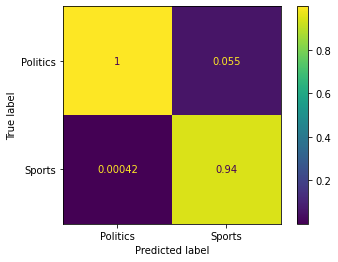

In [10]:
y_predict = clf.predict(X_train)

print("{}\nscore train: {:.2} test: {:.2}".format(
    classification_report(y_train, y_predict),
    clf.score(X_train, y_train), clf.score(X_test, y_test)
))

ConfusionMatrixDisplay(
    confusion_matrix(y_train, y_predict, normalize='pred'),
    display_labels=["Politics", "Sports"], 
).plot()

# Predecting the Tweets

In [11]:
test_df = pd.read_csv("../input/deeptweets/test.csv")
test_df = process_tweets(test_df, log=False)

test_df["Label"] = clf.predict(test_df["TweetWords"])

sample_tweets(test_df)

results = test_df[["TweetId", "Label"]].reset_index(drop=True)
results.to_csv("submission.csv", index=False)

`7 Feb, 10amEST` could not be parse as date
  306486520121012224 Sports     28. The home side threaten again through Mason Bennett after he gets on the end of a long, long throw and stabs a yard wide.
  286353402605228032 Sports     @mrbrown @aulia Thx for asking. See http://t.co/yGJePjkf. It derives from a series of abbreviations for pound avoirdupois, a unit of mass.
  289531046037438464 Sports     @Sochi2014 construction along the shores of the Black Sea http://t.co/8dVIn7wJ
  306451661403062273 Politics   #SecKerrys remarks after meeting with Foreign Minister Westerwelle. Transcript: http://t.co/B2J8GGfxhP | Video: http://t.co/4Qx0FhYpmP
  297941800658812928 Sports     The #IPLauction has begun. Ricky Ponting is the first player to go under the hammer. He goes to Mumbai Indians for base price of USD 400,000
  305722428531802112 Sports     Viswanathan Anand draws with Fabiano Caruana at Zurich http://t.co/35gG3Nw8gn
  304713516256997377 Sports     Have your say on tonight's game - s